<a href="https://colab.research.google.com/github/abrahamt-e/cnn-test/blob/main/Fer_2013_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.8 MB/s eta 0:00:00


Saving archive (1).zip to archive (1).zip


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Epoch 1/25
Train Loss: 2.5563, Accuracy: 0.1879
Test Accuracy: 0.3576

Epoch 2/25
Train Loss: 1.9484, Accuracy: 0.3058
Test Accuracy: 0.2552

Epoch 3/25
Train Loss: 1.8651, Accuracy: 0.3729
Test Accuracy: 0.4869

Epoch 4/25
Train Loss: 1.8226, Accuracy: 0.4144
Test Accuracy: 0.5170

Epoch 5/25
Train Loss: 1.7721, Accuracy: 0.4490
Test Accuracy: 0.5424

Epoch 6/25
Train Loss: 1.7546, Accuracy: 0.4678
Test Accuracy: 0.5531

Epoch 7/25
Train Loss: 1.7105, Accuracy: 0.4942
Test Accuracy: 0.5680

Epoch 8/25
Train Loss: 1.6915, Accuracy: 0.5063
Test Accuracy: 0.5748

Epoch 9/25
Train Loss: 1.6808, Accuracy: 0.5174
Test Accuracy: 0.5978

Epoch 10/25
Train Loss: 1.6548, Accuracy: 0.5318
Test Accuracy: 0.5653

Epoch 11/25
Train Loss: 1.6587, Accuracy: 0.5338
Test Accuracy: 0.6032

Epoch 12/25
Train Loss: 1.6329, Accuracy: 0.5441
Test Accuracy: 0.6174

Epoch 13/25
Train Loss: 1.5883, Accuracy: 0.5707
Test Accuracy: 0.6113

Epoch 14/25
Train Loss: 1.5736, Accuracy: 0.5802
Test Accuracy: 0.6167



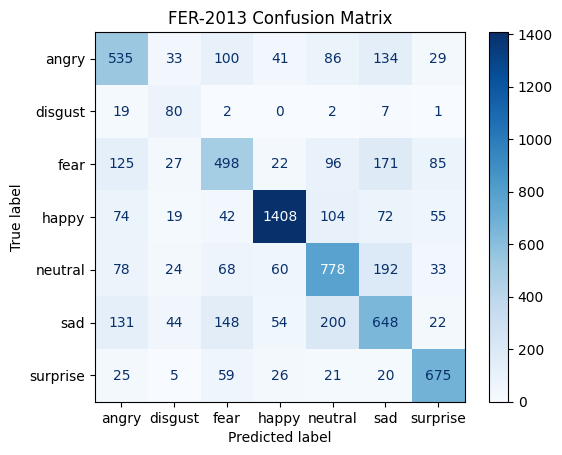

In [17]:
# STEP 1: Install dependencies
!pip install -q albumentations==1.3.1 timm

# STEP 2: Upload the ZIP file
from google.colab import files
uploaded = files.upload()  # Upload "archive (1).zip"

# STEP 3: Extract dataset
import zipfile, os

with zipfile.ZipFile("archive (1).zip", 'r') as zip_ref:
    zip_ref.extractall("fer2013")

# STEP 4: Imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

# STEP 5: Custom Dataset with Albumentations
class AlbumentationsDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.dataset = ImageFolder(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        image = np.array(Image.open(img_path).convert("L"))  # grayscale
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

# STEP 6: Transforms
train_transform = A.Compose([
    A.Resize(48, 48),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(48, 48),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

# STEP 7: Load datasets
train_dataset = AlbumentationsDataset("fer2013/train", transform=train_transform)
test_dataset = AlbumentationsDataset("fer2013/test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# STEP 8: Class weights
labels = [label for _, label in train_dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# STEP 9: Load EfficientNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("efficientnet_b0", pretrained=True, in_chans=1, num_classes=7)
model = model.to(device)

# STEP 10: Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device), label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

# STEP 11: MixUp Function
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0)).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# STEP 12: Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=25):
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (lam * preds.eq(targets_a).sum() + (1 - lam) * preds.eq(targets_b).sum())

        scheduler.step()
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects / len(train_loader.dataset)
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        test_corrects = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        test_acc = test_corrects.double() / len(test_loader.dataset)
        print(f"Test Accuracy: {test_acc:.4f}")

    return model, y_true, y_pred

# STEP 13: Train the Model
model, y_true, y_pred = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=25)

# STEP 14: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_loader.dataset.dataset.classes)
disp.plot(cmap='Blues')
plt.title("FER-2013 Confusion Matrix")
plt.show()


In [38]:
from google.colab import files
uploaded = files.upload()

Saving alnacreap.jpg to alnacreap.jpg


In [39]:
from PIL import Image
import cv2

def preprocess_image(img_path):
    image = Image.open(img_path).convert("L")  # convert to grayscale
    image = image.resize((48, 48))
    image = np.array(image).astype(np.float32) / 255.0
    image = (image - 0.5) / 0.5  # normalize
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 48, 48]
    return image.to(device)

Predicted emotion: happy


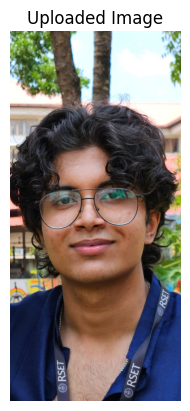

In [43]:
emotion_labels = train_loader.dataset.dataset.classes  # same order as training

def predict_emotion(image_tensor):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        return emotion_labels[predicted.item()]

# Example usage:
img_path = "abhinavneautral.jpg"
image_tensor = preprocess_image(img_path)
prediction = predict_emotion(image_tensor)
print("Predicted emotion:", prediction)
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()
